In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

import pickle


import matplotlib.pyplot as plt
plt.rc('font', family='serif')

import seaborn as sns
sns.set_context("paper", rc={"font.size":13,"axes.titlesize":13,"axes.labelsize":13,"xtick.labelsize":12,"ytick.labelsize":12})  


hue_order = ['LSTM', 'VLSTM-alpha:bounded', 'VLSTM-alpha:free']


2023-07-05 20:31:52.380827: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
from pathlib import Path
import pickle

dirResults="results"
dirPlots=dirResults+"/plots"
dirHistory=dirResults+"/history"
dirModels=dirResults+"/models"



In [3]:


def load_losses(filename,disregard_bounded_alpha=True):
    file_stats = os.stat(filename)
    if file_stats.st_size<100:
        print("filename has size "+file_stats.st_size)
        return None
    
    with open(filename,"rb") as file:
        history=pickle.load(file)

    #history=pd.DataFrame(history)

    tabl=filename.split("_")[1:]    # get parameters from file name
    
   #pdb.set_trace()
    
    if "VLSTM" in filename:
        V=True
    else:
        V=False
        
        
    sel_params=[":" in x for x in tabl]
    params=[tabl[i] for i in np.where(sel_params)[0]]
    
    
    dataType=tabl[0]

    params_split=[a.split(":") for a in params]
    DF=pd.DataFrame(params_split).T
    DF.columns=DF.iloc[0]
    DF=DF.drop(0)
    
    if "loss_test" in DF.columns.to_list():
        DF.rename(columns={"loss_test":"test_loss"})
    
    #pdb.set_trace()
    DF["NH"]=DF["NH"].astype("int")
    DF["Tseq"]=DF["Tseq"].astype("int")
    
    DF["V"]=V
    DF["file"]=filename
    DF["history"]=[history]
    
    if "LSTM" in DF.columns:
        DF.drop(columns="LSTM",inplace=True)
    if "VLSTM" in DF.columns:
        DF.drop(columns="VLSTM",inplace=True)
    
    if not "boundalpha" in DF.columns:
        DF.insert(5, 'NN', "LSTM")
    else:
        DF.rename(columns={"boundalpha":"NN"},inplace=True)
        DF.columns
        #pdb.set_trace()
        if disregard_bounded_alpha:
            DF["NN"]="VLSTM"
        else:
            if DF["NN"].values=="True":
                DF["NN"]="VLSTM-alpha:bounded"
            else:
                DF["NN"]="VLSTM-alpha:free"
    if DF["bias"].values=="True":
        DF["NN"]=DF["NN"]+" bias"
    else:
        DF["NN"]=DF["NN"]+" no bias"

    
        
    return DF

In [159]:
from glob import glob

whats=["*BEDOFIH2_dT_shift*","*BEDOFIH_dT*","*BEDOFIH2_dT_shift*","*SPX*","*Oxf_all_log_rk*","*YF_GSPC_log_volRS*","*0.1*fbm*","*0.65*fbm*","*scale*True*"]

what=whats[4]
what_suffix=what.replace("*","")


In [160]:
files_history=glob(dirHistory+"/"+what)
files_history.sort()
files_history

files_size=np.array([os.stat(myfile).st_size for myfile in files_history])
sel=files_size>0
files_history=np.array(files_history)[np.where(sel)]

sel=[myfile.find("boundalpha:False")<0 for myfile in files_history]
files_history=np.array(files_history)[np.where(sel)]

In [161]:
try:
    import pqdm
except ImportError as e:
    %pip install pqdm
    import pqdm
    
from pqdm.processes import pqdm


In [162]:
allres=pqdm(files_history,load_losses,8,disable=True)
len(allres)

2800

In [163]:
allres=pd.concat(allres)
allres["conv_time"]=allres["history"].apply(lambda df: len(df["loss"]))
allres

0   NH   bias  Tseq batchSize predictors            NN     run      V  \
1    1  False   100       128       open  LSTM no bias   0.pkl  False   
1    1  False   100       128       open  LSTM no bias   1.pkl  False   
1    1  False   100       128       open  LSTM no bias  10.pkl  False   
1    1  False   100       128       open  LSTM no bias  11.pkl  False   
1    1  False   100       128       open  LSTM no bias  12.pkl  False   
..  ..    ...   ...       ...        ...           ...     ...    ...   
1    5   True    85       128       open    VLSTM bias   5.pkl   True   
1    5   True    85       128       open    VLSTM bias   6.pkl   True   
1    5   True    85       128       open    VLSTM bias   7.pkl   True   
1    5   True    85       128       open    VLSTM bias   8.pkl   True   
1    5   True    85       128       open    VLSTM bias   9.pkl   True   

0                                                file  \
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
..                                                ...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   

0                                             history  conv_time  
1   {'loss': [72.17217254638672, 52.5828857421875,...         28  
1   {'loss': [68.6253662109375, 45.04630661010742,...         18  
1   {'loss': [70.94640350341797, 51.77887344360351...         20  
1   {'loss': [68.69043731689453, 49.13201141357422...         94  
1   {'loss': [65.25685119628906, 44.06398773193359...         25  
..                                                ...        ...  
1   {'loss': [60.56132507324219, 26.68630027770996...         42  
1   {'loss': [49.47344970703125, 14.13885879516601...         34  
1   {'loss': [47.86875915527344, 18.22714233398437...        276  
1   {'loss': [81.7154312133789, 45.50288009643555,...        166  
1   {'loss': [37.29895782470703, 8.039478302001953...         15  

[2800 rows x 11 columns]

In [164]:
allres["NN"].unique()

array(['LSTM no bias', 'LSTM bias', 'VLSTM no bias', 'VLSTM bias'],
      dtype=object)

In [165]:
allres["last_val_loss"]=allres["history"].apply(lambda x: x['val_loss'][-1])
allres["last_loss"]=allres["history"].apply(lambda x: x['loss'][-1])
allres["test_loss"]=allres["history"].apply(lambda x: x["loss_test"])
allres["test_accuracy"]=allres["history"].apply(lambda x: x["accuracy"] if "accuracy" in x else np.nan)
allres["test_f1"]=allres["history"].apply(lambda x: x["f1"] if "f1" in x else np.nan)


allres["last_val_loss_log"]=np.log(allres["history"].apply(lambda x: x['val_loss'][-1]))

In [166]:
allres=allres.assign(key=allres.NH.map(str) +"_"+ allres.Tseq.map(str) +"_"+ allres.NN.map(str))
allres

0   NH   bias  Tseq batchSize predictors            NN     run      V  \
1    1  False   100       128       open  LSTM no bias   0.pkl  False   
1    1  False   100       128       open  LSTM no bias   1.pkl  False   
1    1  False   100       128       open  LSTM no bias  10.pkl  False   
1    1  False   100       128       open  LSTM no bias  11.pkl  False   
1    1  False   100       128       open  LSTM no bias  12.pkl  False   
..  ..    ...   ...       ...        ...           ...     ...    ...   
1    5   True    85       128       open    VLSTM bias   5.pkl   True   
1    5   True    85       128       open    VLSTM bias   6.pkl   True   
1    5   True    85       128       open    VLSTM bias   7.pkl   True   
1    5   True    85       128       open    VLSTM bias   8.pkl   True   
1    5   True    85       128       open    VLSTM bias   9.pkl   True   

0                                                file  \
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
..                                                ...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   
1   results/history/history_Oxf_all_log_rk_twoscal...   

0                                             history  conv_time  \
1   {'loss': [72.17217254638672, 52.5828857421875,...         28   
1   {'loss': [68.6253662109375, 45.04630661010742,...         18   
1   {'loss': [70.94640350341797, 51.77887344360351...         20   
1   {'loss': [68.69043731689453, 49.13201141357422...         94   
1   {'loss': [65.25685119628906, 44.06398773193359...         25   
..                                                ...        ...   
1   {'loss': [60.56132507324219, 26.68630027770996...         42   
1   {'loss': [49.47344970703125, 14.13885879516601...         34   
1   {'loss': [47.86875915527344, 18.22714233398437...        276   
1   {'loss': [81.7154312133789, 45.50288009643555,...        166   
1   {'loss': [37.29895782470703, 8.039478302001953...         15   

0   last_val_loss  last_loss  test_loss  test_accuracy  test_f1  \
1        0.586630   0.489094   0.645264            NaN      NaN   
1        1.047766   0.952089   1.440104            NaN      NaN   
1        1.111260   0.981744   1.347113            NaN      NaN   
1        0.242058   0.255996   0.252745            NaN      NaN   
1        1.060556   0.705377   1.051458            NaN      NaN   
..            ...        ...        ...            ...      ...   
1        0.226988   0.240420   0.225417            NaN      NaN   
1        0.227371   0.243730   0.231094            NaN      NaN   
1        0.216071   0.230984   0.213024            NaN      NaN   
1        0.219442   0.232946   0.214750            NaN      NaN   
1        0.256737   0.249693   0.267136            NaN      NaN   

0   last_val_loss_log                 key  
1           -0.533362  1_100_LSTM no bias  
1            0.046660  1_100_LSTM no bias  
1            0.105495  1_100_LSTM no bias  
1           -1.418580  1_100_LSTM no bias  
1            0.058794  1_100_LSTM no bias  
..                ...                 ...  
1           -1.482859     5_85_VLSTM bias  
1           -1.481173     5_85_VLSTM bias  
1           -1.532150     5_85_VLSTM bias  
1           -1.516666     5_85_VLSTM bias  
1           -1.359702     5_85_VLSTM bias  

[2800 rows x 18 columns]

In [167]:
allres[["NH","Tseq", "V","last_val_loss","last_loss","test_loss"]]

0   NH  Tseq      V  last_val_loss  last_loss  test_loss
1    1   100  False       0.586630   0.489094   0.645264
1    1   100  False       1.047766   0.952089   1.440104
1    1   100  False       1.111260   0.981744   1.347113
1    1   100  False       0.242058   0.255996   0.252745
1    1   100  False       1.060556   0.705377   1.051458
..  ..   ...    ...            ...        ...        ...
1    5    85   True       0.226988   0.240420   0.225417
1    5    85   True       0.227371   0.243730   0.231094
1    5    85   True       0.216071   0.230984   0.213024
1    5    85   True       0.219442   0.232946   0.214750
1    5    85   True       0.256737   0.249693   0.267136

[2800 rows x 6 columns]

In [168]:
allres_avg=allres[["NH","Tseq", "NN","test_loss"]].groupby(["NH","Tseq", "NN"]).mean()
allres_avg=allres_avg.reset_index()
allres_avg

0    NH  Tseq             NN  test_loss
0     1    10      LSTM bias   0.335319
1     1    10   LSTM no bias   0.444212
2     1    10     VLSTM bias   0.409976
3     1    10  VLSTM no bias   0.309958
4     1    25      LSTM bias   0.534030
..   ..   ...            ...        ...
135   5    85  VLSTM no bias   0.225741
136   5   100      LSTM bias   0.408786
137   5   100   LSTM no bias   0.246011
138   5   100     VLSTM bias   0.239231
139   5   100  VLSTM no bias   0.224531

[140 rows x 4 columns]

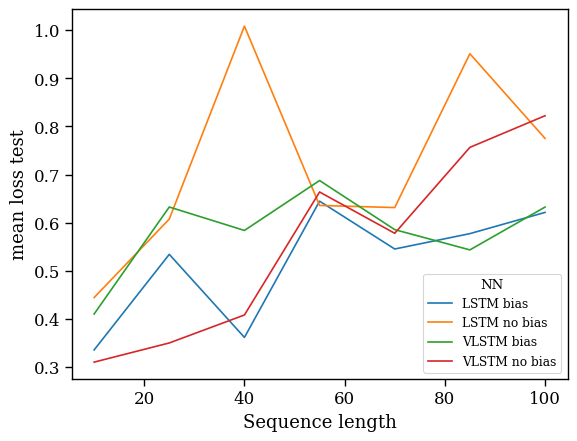

In [169]:
NH=1
sns.lineplot(data=allres_avg[allres_avg["NH"]==NH],x="Tseq",y="test_loss",hue="NN")#,hue_order=hue_order)
plt.xlabel("Sequence length")
plt.ylabel("mean loss test")
plt.savefig(what_suffix+"_mean_loss_test_vs_Tseq_NH1.pdf")

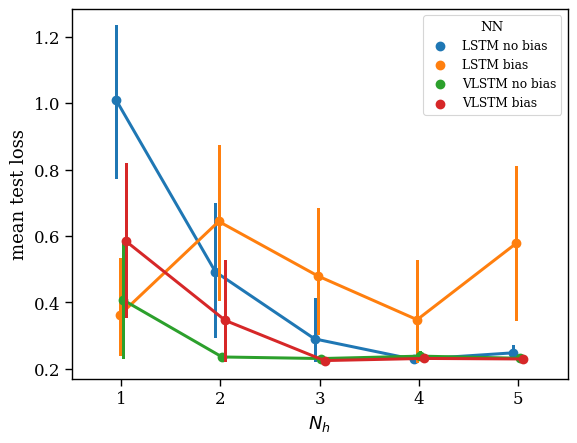

In [170]:
Tseq=40
sns.pointplot(data=allres[(allres["Tseq"]==Tseq)],x="NH",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)
plt.xlabel(r"$N_h$")
plt.ylabel("mean test loss")
plt.savefig(what_suffix+"_mean_ci_loss_test_vs_NH_Tseq"+str(Tseq)+".pdf")

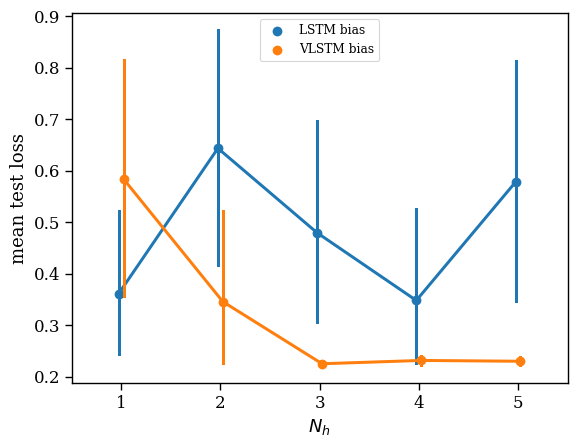

In [171]:
Tseq=40
sns.pointplot(data=allres[(allres["Tseq"]==Tseq) & (allres["bias"]=="True")],x="NH",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)
plt.xlabel(r"$N_h$")
plt.ylabel("mean test loss")
plt.legend(title="")
plt.savefig(what_suffix+"_mean_ci_loss_test_vs_NH_Tseq"+str(Tseq)+"_BiasTrue.pdf")

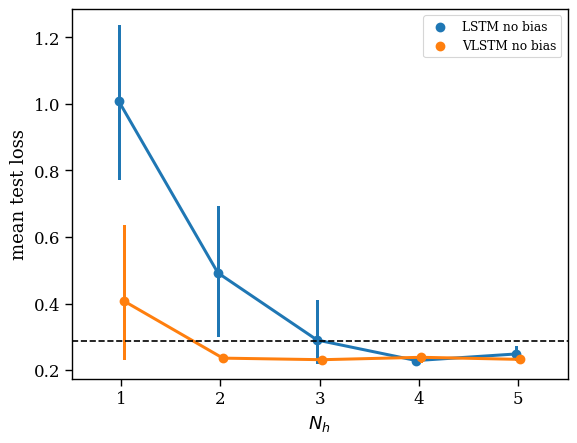

In [245]:
Tseq=40
sns.pointplot(data=allres[(allres["Tseq"]==Tseq) & (allres["bias"]=="False")],x="NH",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)
plt.xlabel(r"$N_h$")
plt.ylabel("mean test loss")
plt.legend(title="")
plt.axhline(y=0.2878608353564752, color='black',linestyle="--") 

plt.savefig(what_suffix+"_mean_ci_loss_test_vs_NH_Tseq"+str(Tseq)+"_BiasFalse.pdf")

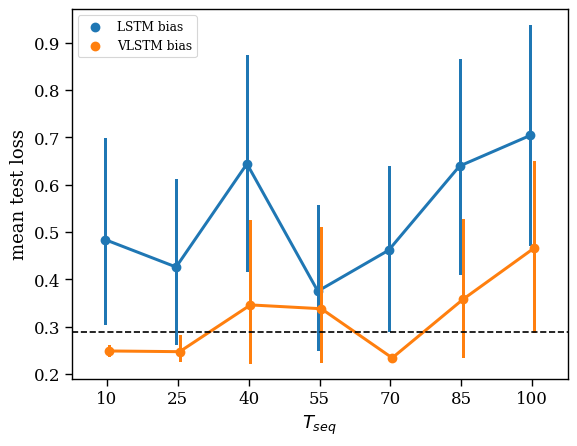

In [242]:
NH=2
sns.pointplot(data=allres[(allres["NH"]==NH) & (allres["bias"]=="True")],x="Tseq",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)
plt.xlabel(r"$T_{seq}$")
plt.ylabel("mean test loss")
plt.legend(title="")
plt.axhline(y=0.2878608353564752, color='black',linestyle="--") 

plt.savefig(what_suffix+"_mean_ci_loss_test_vs_Tseq_NH"+str(NH)+"_BiasTrue.pdf")

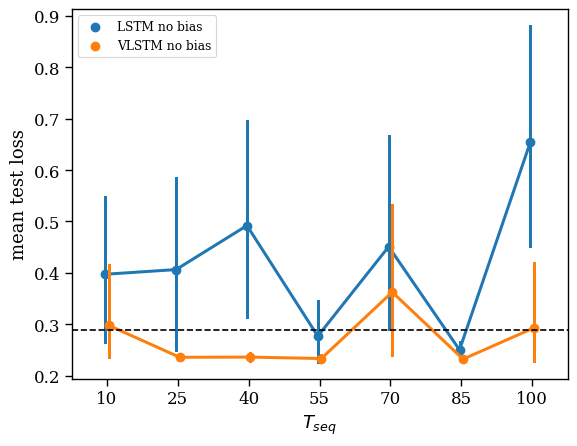

In [243]:
NH=2
sns.pointplot(data=allres[(allres["NH"]==NH) & (allres["bias"]=="False")],x="Tseq",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)
plt.xlabel(r"$T_{seq}$")
plt.ylabel("mean test loss")
plt.legend(title="")
plt.axhline(y=0.2878608353564752, color='black',linestyle="--") 

plt.savefig(what_suffix+"_mean_ci_loss_test_vs_Tseq_NH"+str(NH)+"_BiasFalse.pdf")

In [175]:

Tseq=40
if False:
    sns.pointplot(data=allres[(allres["Tseq"]==Tseq) & (allres["bias"]=="True") & np.isfinite(allres["test_accuracy"])],x="NH",y="test_accuracy",hue="NN",dodge=True)
    plt.xlabel(r"$N_h$")
    plt.ylabel("mean test accuracy")
    plt.savefig(what_suffix+"_mean_loss_test_vs_NH_Tseq"+str(Tseq)+"_BiasTrue.pdf")

    Tseq=60
    sns.pointplot(data=allres[(allres["Tseq"]==Tseq) & (allres["bias"]=="False") & np.isfinite(allres["test_accuracy"])],x="NH",y="test_f1",hue="NN",dodge=True)
    plt.xlabel(r"$N_h$")
    plt.ylabel("mean test accuracy")
    plt.savefig(what_suffix+"_mean_loss_test_vs_NH_Tseq"+str(Tseq)+"_BiasFalse.pdf")

In [181]:
allres_val_best=allres[["NH","Tseq", "NN","test_loss","last_val_loss","conv_time","bias"]].groupby(["NH","Tseq", "NN"]).apply(lambda df: df[df["last_val_loss"]<df["last_val_loss"].mean() ])
allres_val_best=allres_val_best.reset_index(drop=True) 

In [182]:
allres_acc_best=allres[["NH","Tseq", "NN","test_loss","last_val_loss","conv_time","bias"]].groupby(["NH","Tseq", "NN"]).apply(lambda df: df[df["last_val_loss"]<df["last_val_loss"].mean() ])
allres_val_best=allres_val_best.reset_index(drop=True) 

In [183]:
allres_val_bestavg=allres[["NH","Tseq", "NN","test_loss","last_val_loss"]].groupby(["NH","Tseq", "NN"]).apply(lambda df: df.iloc[np.where(df["last_val_loss"]<df["last_val_loss"].mean())]["test_loss"].mean())
allres_val_bestavg=allres_val_bestavg.reset_index(name='test_loss')

In [184]:
allres_val_bestbest=allres[["NH","Tseq", "NN","test_loss","last_val_loss","conv_time"]].groupby(["NH","Tseq", "NN"]).apply(lambda df: df.iloc[np.where(df["last_val_loss"]==min(df["last_val_loss"]))])[["conv_time","test_loss"]]
allres_val_bestbest
#allres_val_bestbest=allres_val_bestbest.reset_index(name='test_loss')

0                        conv_time  test_loss
NH Tseq NN                                   
1  10   LSTM bias     1       1000   0.227624
        LSTM no bias  1       1000   0.232465
        VLSTM bias    1        549   0.228931
        VLSTM no bias 1        273   0.230463
   25   LSTM bias     1       1000   0.223047
...                            ...        ...
5  85   VLSTM no bias 1         78   0.213464
   100  LSTM bias     1        350   0.213513
        LSTM no bias  1        457   0.214368
        VLSTM bias    1        127   0.215874
        VLSTM no bias 1        141   0.212297

[140 rows x 2 columns]

In [185]:
allres_val_bestbest

0                        conv_time  test_loss
NH Tseq NN                                   
1  10   LSTM bias     1       1000   0.227624
        LSTM no bias  1       1000   0.232465
        VLSTM bias    1        549   0.228931
        VLSTM no bias 1        273   0.230463
   25   LSTM bias     1       1000   0.223047
...                            ...        ...
5  85   VLSTM no bias 1         78   0.213464
   100  LSTM bias     1        350   0.213513
        LSTM no bias  1        457   0.214368
        VLSTM bias    1        127   0.215874
        VLSTM no bias 1        141   0.212297

[140 rows x 2 columns]

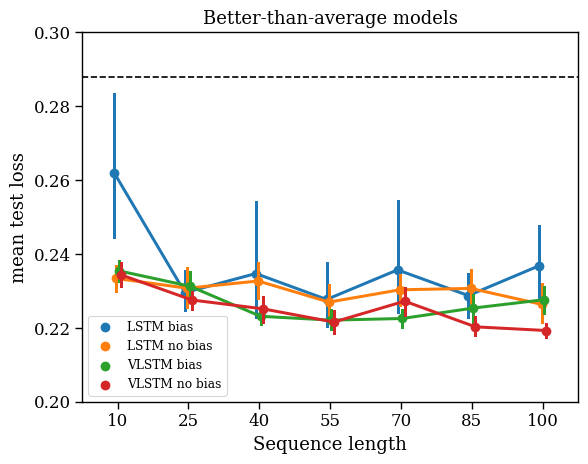

In [244]:
NH=5
sns.pointplot(data=allres_val_best[allres_val_best["NH"]==NH],x="Tseq",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)
plt.xlabel("Sequence length")
plt.ylabel("mean test loss")
plt.ylim((0.2,0.3))
plt.title("Better-than-average models")
plt.legend(title="")
plt.axhline(y=0.2878608353564752, color='black',linestyle="--") 
plt.savefig(what_suffix+"_mean_condval_loss_test_vs_Tseq_NH"+str(NH)+".pdf")

In [187]:
allres_val_bestbest

0                        conv_time  test_loss
NH Tseq NN                                   
1  10   LSTM bias     1       1000   0.227624
        LSTM no bias  1       1000   0.232465
        VLSTM bias    1        549   0.228931
        VLSTM no bias 1        273   0.230463
   25   LSTM bias     1       1000   0.223047
...                            ...        ...
5  85   VLSTM no bias 1         78   0.213464
   100  LSTM bias     1        350   0.213513
        LSTM no bias  1        457   0.214368
        VLSTM bias    1        127   0.215874
        VLSTM no bias 1        141   0.212297

[140 rows x 2 columns]

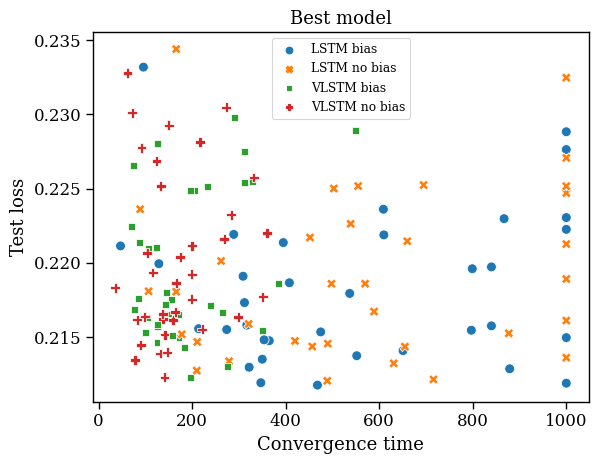

In [235]:
sns.scatterplot(data=allres_val_bestbest,x="conv_time",y="test_loss",s=50,style="NN",hue="NN")#,dodge=True)#,hue_order=hue_order)
plt.xlabel("Convergence time")
plt.ylabel("Test loss")
plt.title("Best model")
plt.legend(title="")
#plt.ylim((0.2,0.25))

plt.savefig(what_suffix+"_conv_time_bestval_loss_test.pdf")

In [200]:
allres_val_bestbest.reset_index(inplace=True)

In [204]:
allres_val_bestbest["NN"]

0          LSTM bias
1       LSTM no bias
2         VLSTM bias
3      VLSTM no bias
4          LSTM bias
           ...      
135    VLSTM no bias
136        LSTM bias
137     LSTM no bias
138       VLSTM bias
139    VLSTM no bias
Name: NN, Length: 140, dtype: object

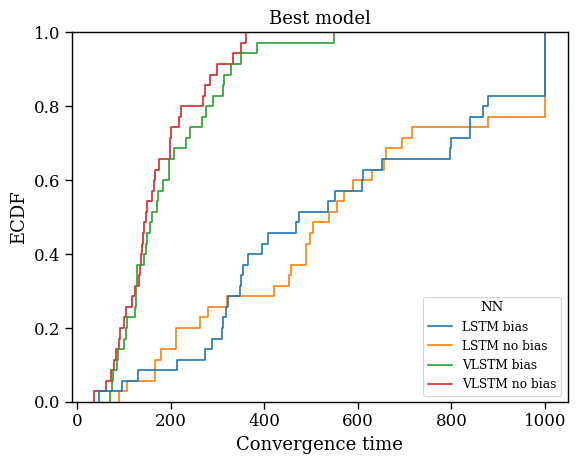

In [234]:
ax=sns.ecdfplot(data=allres_val_bestbest[["NN","conv_time"]],x="conv_time",hue="NN")#,dodge=True)#,hue_order=hue_order)
plt.xlabel("Convergence time")
plt.ylabel("ECDF")
plt.title("Best model")
sns.despine(bottom = False, left = False, top = False, right = False)

#sns.move_legend(ax, "lower right", bbox_to_anchor=(.93, .2), ncol=1, title_fontsize=13, frameon=True)
#plt.legend(title="", fontsize="x-large") 
plt.savefig(what_suffix+"_density_conv_time_bestval_loss_test.pdf")

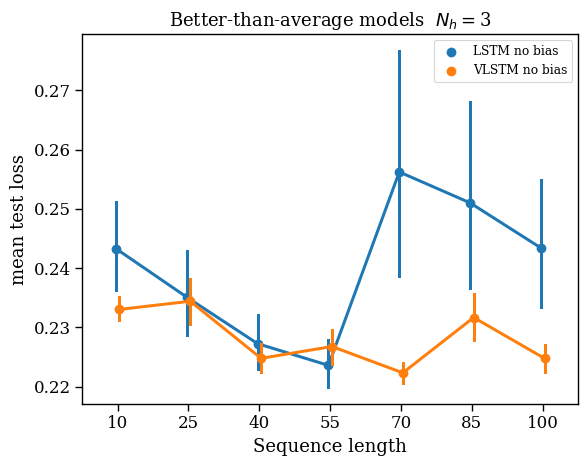

In [190]:
NH=3
sns.pointplot(data=allres_val_best[(allres_val_best["NH"]==NH) & (allres_val_best["bias"]=="False")],x="Tseq",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)
plt.xlabel("Sequence length")
plt.ylabel("mean test loss")
plt.title("Better-than-average models  "+r"$N_h=$"+str(NH))
plt.legend(title="")

plt.savefig(what_suffix+"_mean_condval_loss_test_vs_Tseq_NH"+str(NH)+"_biasFalse.pdf")

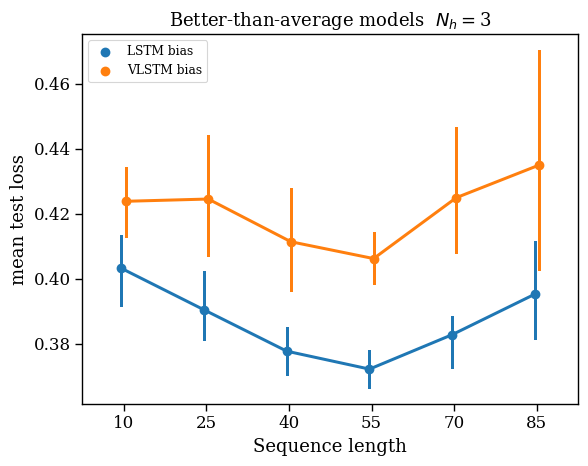

In [139]:
NH=3
sns.pointplot(data=allres_val_best[(allres_val_best["NH"]==NH) & (allres_val_best["bias"]=="True")],x="Tseq",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)
plt.xlabel("Sequence length")
plt.ylabel("mean test loss")
plt.title("Better-than-average models  "+r"$N_h=$"+str(NH))
plt.legend(title="")

plt.savefig(what_suffix+"_mean_condval_loss_test_vs_Tseq_NH"+str(NH)+"_biasTrue.pdf")

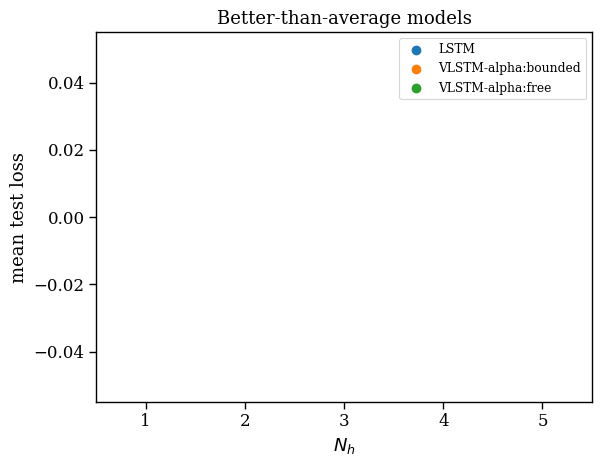

In [140]:
Tseq=40
#sns.lineplot(data=allres_val_bestavg[allres_val_bestavg["Tseq"]==Tseq],x="NH",y="test_loss",hue="NN")
sns.pointplot(data=allres_val_best[allres_val_best["Tseq"]==Tseq],x="NH",y="test_loss",hue="NN",dodge=True,hue_order=hue_order)

plt.xlabel(r"$N_h$")
plt.ylabel("mean test loss")
plt.title("Better-than-average models")
plt.legend(title="")

plt.savefig(what_suffix+"_mean_condval_loss_test_vs_NH_Tseq"+str(Tseq)+".pdf")

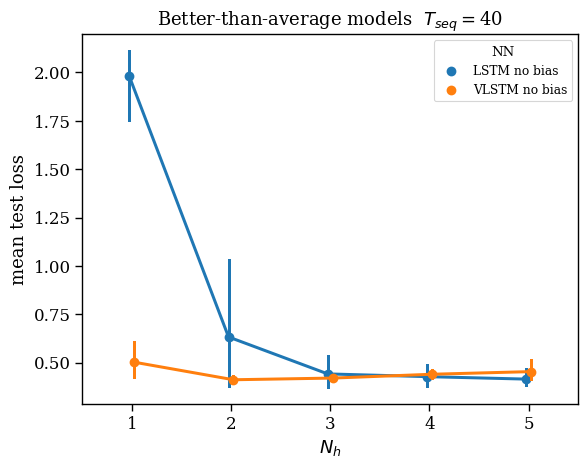

In [141]:
Tseq=40
#sns.lineplot(data=allres_val_bestavg[allres_val_bestavg["Tseq"]==Tseq],x="NH",y="test_loss",hue="NN")
sns.pointplot(data=allres_val_best[(allres_val_best["Tseq"]==Tseq) & (allres_val_best["bias"]=="False")],x="NH",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)

plt.xlabel(r"$N_h$")
plt.ylabel("mean test loss")
plt.title("Better-than-average models  "+r"$T_{seq}=$"+str(Tseq))
plt.savefig(what_suffix+"_mean_condval_loss_test_vs_NH_Tseq_biasFalse"+str(Tseq)+".pdf")

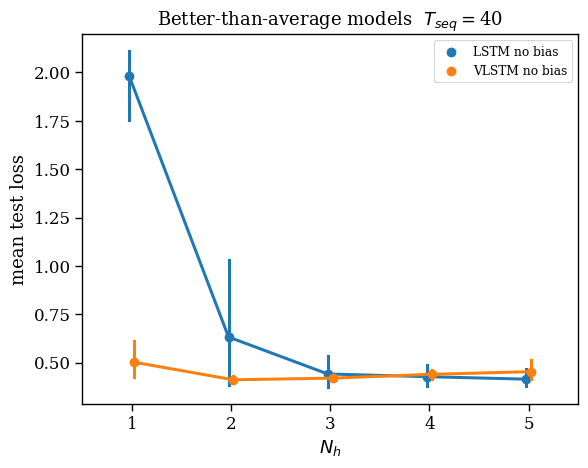

In [142]:
Tseq=40
#sns.lineplot(data=allres_val_bestavg[allres_val_bestavg["Tseq"]==Tseq],x="NH",y="test_loss",hue="NN")
sns.pointplot(data=allres_val_best[(allres_val_best["Tseq"]==Tseq) & (allres_val_best["bias"]=="False")  & ( "VLSTM-alpha:free False" != allres_val_best["NN"])],x="NH",y="test_loss",hue="NN",dodge=True)#,hue_order=hue_order)

plt.xlabel(r"$N_h$")
plt.ylabel("mean test loss")
plt.title("Better-than-average models  "+r"$T_{seq}=$"+str(Tseq))
plt.legend(title="")

plt.savefig(what_suffix+"_mean_condval_loss_test_vs_NH_Tseq_biasFalse_without_free"+str(Tseq)+".pdf")

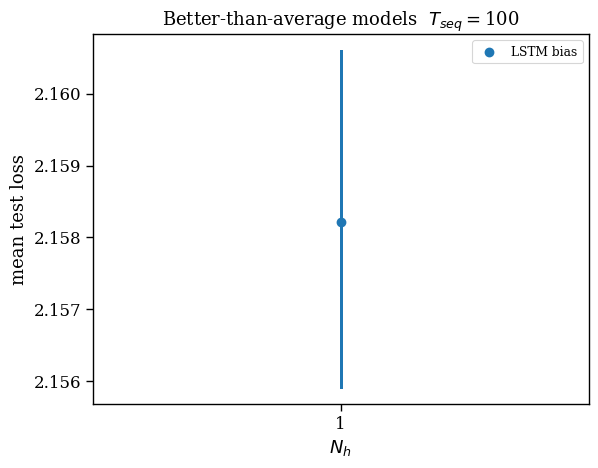

In [143]:
Tseq=100
#sns.lineplot(data=allres_val_bestavg[allres_val_bestavg["Tseq"]==Tseq],x="NH",y="test_loss",hue="NN")
sns.pointplot(data=allres_val_best[(allres_val_best["Tseq"]==Tseq) & (allres_val_best["bias"]=="True")],x="NH",y="test_loss",hue="NN",dodge=True)

plt.xlabel(r"$N_h$")
plt.ylabel("mean test loss")
plt.title("Better-than-average models  "+r"$T_{seq}=$"+str(Tseq))
plt.legend(title="")

plt.savefig(what_suffix+"_mean_condval_loss_test_vs_NH_Tseq_biasTrue"+str(Tseq)+".pdf")

In [144]:
Tseq=100
#sns.lineplot(data=allres_val_bestavg[allres_val_bestavg["Tseq"]==Tseq],x="NH",y="test_loss",hue="NN")
sns.pointplot(data=allres_val_best[(allres_val_best["Tseq"]==Tseq) & (allres_val_best["bias"]=="False")],x="NH",y="test_loss",hue="NN",dodge=True)

plt.xlabel(r"$N_h$")
plt.ylabel("mean test loss")
plt.title("Better-than-average models  "+r"$T_{seq}=$"+str(Tseq))
plt.legend(title="")

plt.savefig(what_suffix+"_mean_condval_loss_test_vs_NH_Tseq_biasFalse"+str(Tseq)+".pdf")

ValueError: min() arg is an empty sequence

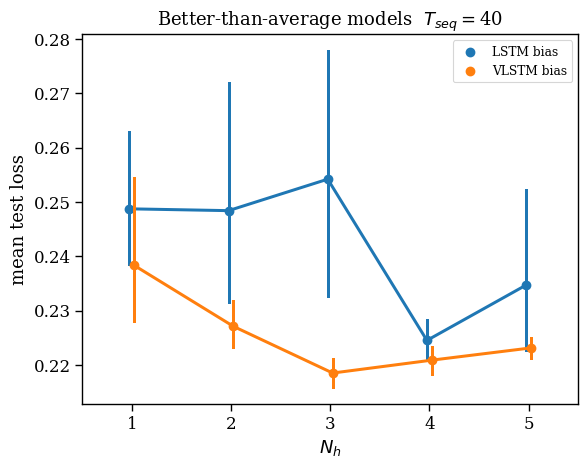

In [106]:
Tseq=40
#sns.lineplot(data=allres_val_bestavg[allres_val_bestavg["Tseq"]==Tseq],x="NH",y="test_loss",hue="NN")
sns.pointplot(data=allres_val_best[(allres_val_best["Tseq"]==Tseq) & (allres_val_best["bias"]=="True") & ( "VLSTM-alpha:free True" != allres_val_best["NN"])],x="NH",y="test_loss",hue="NN",dodge=True)

plt.xlabel(r"$N_h$")
plt.ylabel("mean test loss")
plt.title("Better-than-average models  "+r"$T_{seq}=$"+str(Tseq))
plt.legend(title="")

plt.savefig(what_suffix+"_mean_condval_loss_test_vs_NH_Tseq_biasTrue_without_free"+str(Tseq)+".pdf")

In [34]:
allres_val_best[["NN","test_loss"]].groupby("NN").std()


0              test_loss
NN                      
LSTM bias       0.038331
LSTM no bias    0.056808
VLSTM bias      0.020176
VLSTM no bias   0.020424

In [35]:
allres_val_best[["NN","test_loss"]].groupby("NN").mean()


0              test_loss
NN                      
LSTM bias       0.244890
LSTM no bias    0.246091
VLSTM bias      0.233011
VLSTM no bias   0.232183

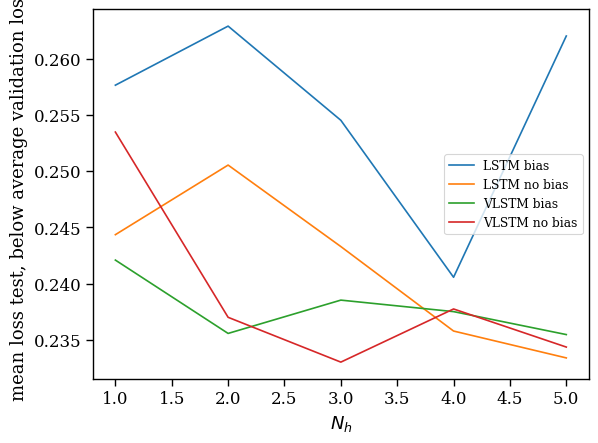

In [36]:
Tseq=10
sns.lineplot(data=allres_val_bestavg[allres_val_bestavg["Tseq"]==Tseq],x="NH",y="test_loss",hue="NN")

plt.xlabel(r"$N_h$")
plt.ylabel("mean loss test, below average validation loss")
plt.legend(title="")

plt.savefig(what_suffix+"_mean_condval_loss_test_vs_NH_Tseq"+str(Tseq)+".pdf")

In [37]:
#allres_val_bestavg.groupby("NH").apply(lambda df: df[df.V==True]["test_loss"].mean()/df[df.V==False]["test_loss"].mean()-1).plot()

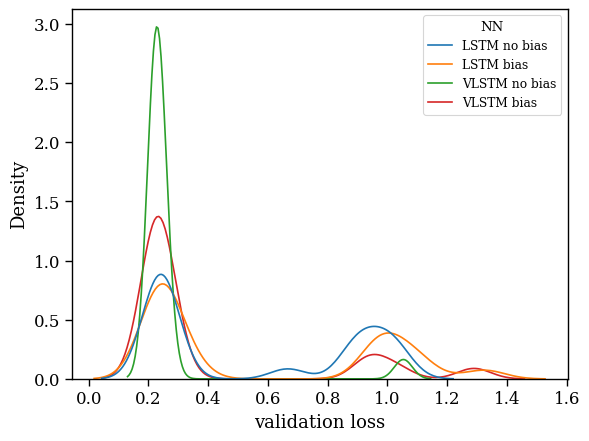

In [38]:
NH=2
Tseq=100
sns.kdeplot(x="last_val_loss",data=allres[(allres["NH"]==NH) &(allres["Tseq"]==Tseq)],hue="NN",bw_adjust=.3)#,hue_order=hue_order)
plt.xlabel("validation loss")
#plt.legend(title="")

plt.savefig(what_suffix+"_validation_loss_density_NH"+str(NH)+"_Tseq"+str(Tseq)+".pdf")
#plt.xscale("log")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


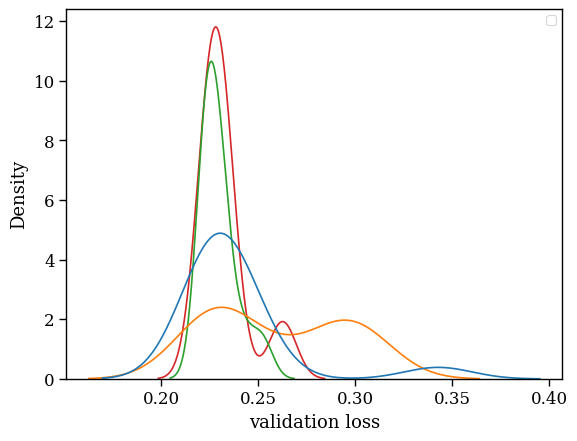

In [39]:
NH=1
Tseq=25
sns.kdeplot(x="last_val_loss",data=allres_val_best[(allres_val_best["NH"]==NH) &(allres_val_best["Tseq"]==Tseq)],hue="NN")#,hue_order=hue_order)
plt.xlabel("validation loss")
plt.legend(title="")

plt.savefig(what_suffix+"_validation_loss_density_NH"+str(NH)+"_Tseq"+str(Tseq)+".pdf")
#plt.xscale("log")

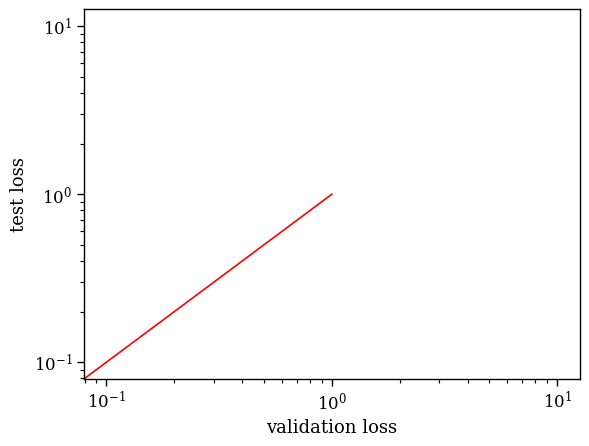

In [40]:
g=sns.scatterplot(x="last_val_loss",y="test_f1",data=allres,hue="NN",sizes="NH",alpha=0.6)
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-r')

plt.xlabel("validation loss")
plt.ylabel("test loss")
plt.xscale("log")
plt.yscale("log")
plt.savefig(what_suffix+"_testloss_vs_valloss.pdf")

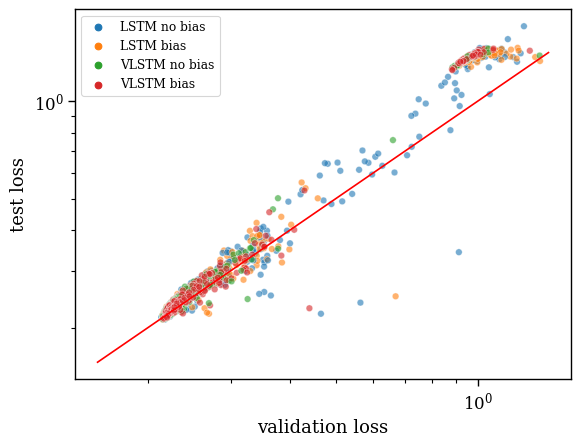

In [41]:
g=sns.scatterplot(x="last_val_loss",y="test_loss",data=allres,hue="NN",sizes="NH",alpha=0.6)#,hue_order=hue_order)
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-r')

plt.xlabel("validation loss")
plt.ylabel("test loss")
plt.xscale("log")
plt.yscale("log")
plt.legend(title="")
plt.savefig(what_suffix+"_testloss_vs_valloss.pdf")

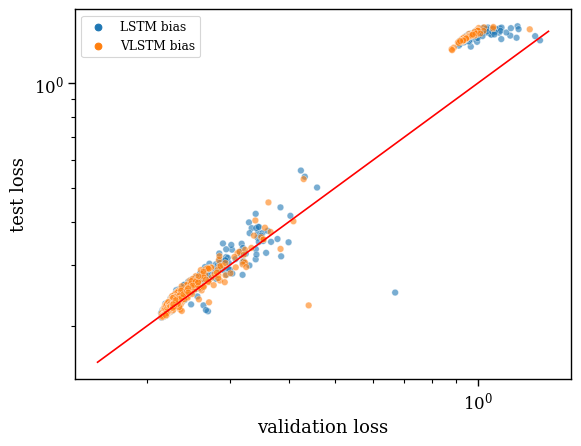

In [42]:
g=sns.scatterplot(x="last_val_loss",y="test_loss",data=allres[allres["bias"]=="True"],hue="NN",sizes="NH",alpha=0.6)#,hue_order=hue_order)
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-r')

plt.xlabel("validation loss")
plt.ylabel("test loss")
plt.xscale("log")
plt.yscale("log")
plt.legend(title="")
plt.savefig(what_suffix+"_testloss_vs_valloss_BiasTrue.pdf")

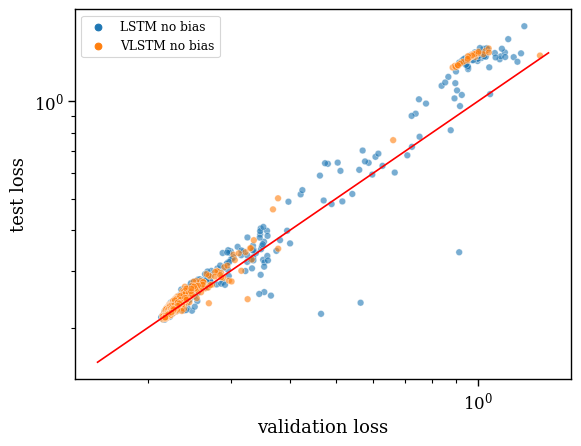

In [43]:
sns.color_palette("Set2")
g=sns.scatterplot(x="last_val_loss",y="test_loss",data=allres[allres["bias"]=="False"],hue="NN",sizes="NH",alpha=0.6)#hue_order=hue_order)
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-r')

plt.xlabel("validation loss")
plt.ylabel("test loss")
plt.xscale("log")
plt.yscale("log")
plt.legend(title="")

plt.savefig(what_suffix+"_testloss_vs_valloss_BiasFalse.pdf")

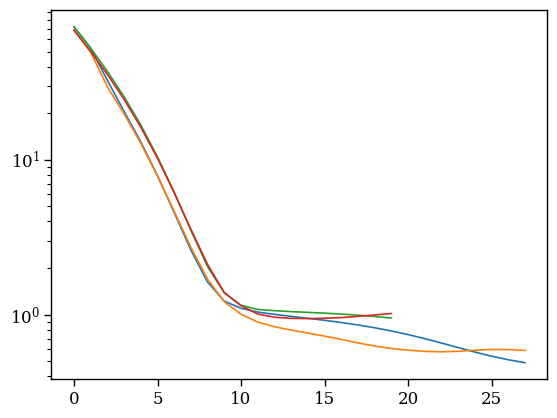

In [44]:
idx=0

plt.plot(allres.iloc[idx]["history"]["loss"])
plt.plot(allres.iloc[idx]["history"]["val_loss"])
plt.plot(allres.iloc[idx+40]["history"]["loss"])
plt.plot(allres.iloc[idx+40]["history"]["val_loss"])


plt.yscale("log")

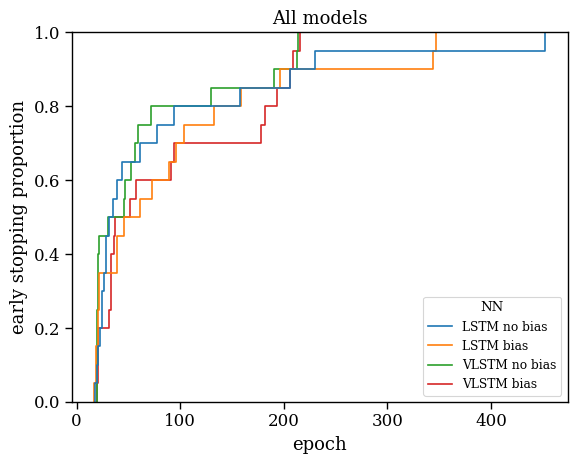

In [216]:
NH=1
Tseq=100
sns.ecdfplot(x="conv_time",data=allres[(allres["NH"]==NH) &(allres["Tseq"]==Tseq)],hue="NN")#,hue_order=hue_order)
plt.xlabel("epoch")
plt.ylabel("early stopping proportion")
plt.title("All models")
#plt.legend(title="")

plt.savefig(what_suffix+"_conv_time_all_val_NH"+str(NH)+"_Tseq"+str(Tseq)+".pdf")

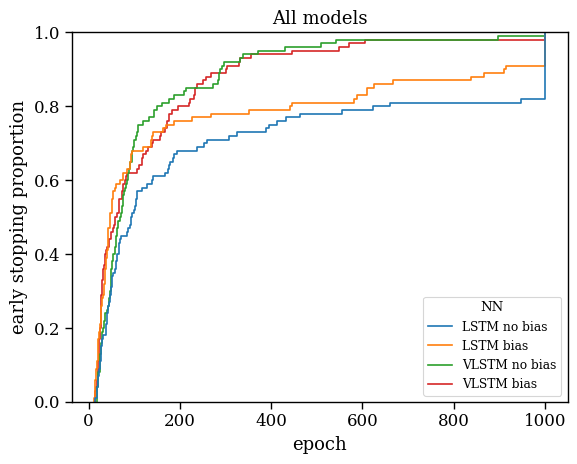

In [46]:
Tseq=10
sns.ecdfplot(x="conv_time",data=allres[(allres["NH"]>0) &(allres["Tseq"]==Tseq)],hue="NN")#,hue_order=hue_order)
plt.xlabel("epoch")
plt.ylabel("early stopping proportion")
plt.title("All models")
plt.savefig(what_suffix+"_conv_time_all_val_NHall"+str(NH)+"_Tseq"+str(Tseq)+".pdf")

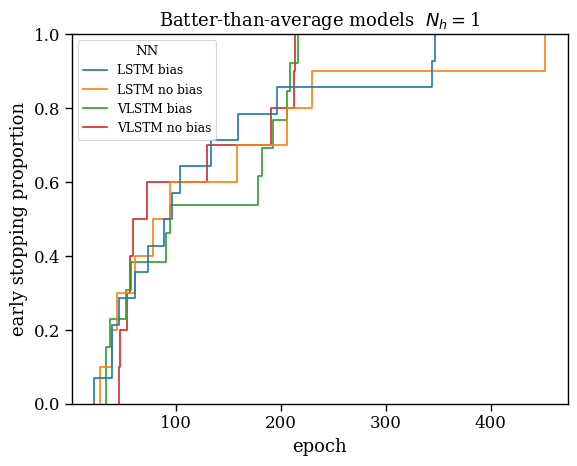

In [107]:
NH=1
Tseq=100
sns.ecdfplot(x="conv_time",data=allres_val_best[(allres_val_best["NH"]==NH) &(allres_val_best["Tseq"]==Tseq)],hue="NN")#,hue_order=hue_order)
plt.xlabel("epoch")
plt.ylabel("early stopping proportion")
plt.title("Batter-than-average models  "+r"$N_h=$"+str(NH))
#plt.legend(title="")

plt.savefig(what_suffix+"_conv_time_best_val_NH"+str(NH)+"_Tseq"+str(Tseq)+".pdf")

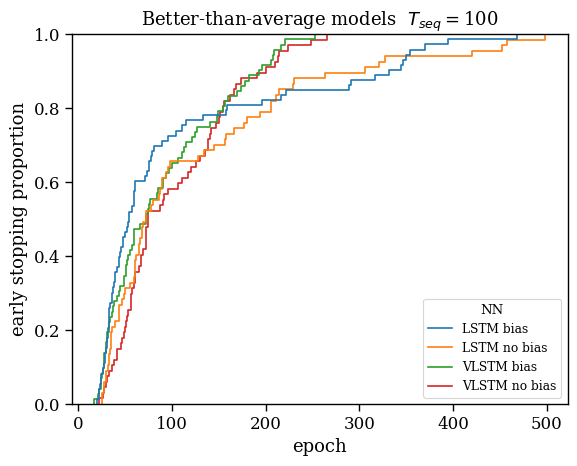

In [109]:
Tseq=100
sns.ecdfplot(x="conv_time",data=allres_val_best[(allres_val_best["NH"]>0) &(allres_val_best["Tseq"]==Tseq)],hue="NN")#,hue_order=hue_order)
plt.xlabel("epoch")
plt.ylabel("early stopping proportion")
plt.title("Better-than-average models  "+r"$T_{seq}=$"+str(Tseq))
plt.savefig(what_suffix+"_conv_time_best_val_NHall"+str(NH)+"_Tseq"+str(Tseq)+".pdf")

In [49]:
print(tf.__version__)

2.11.0
